# Add model: translation attention ecoder-decocer over the b3 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot, plot_confusion_matrix
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

### Preparing data

In [3]:
df2 = pd.read_csv("data/boolean3_train.csv")
df2_test = pd.read_csv("data/boolean3_test.csv")

df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [4]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Milton went to Timisoara and Tulcea,Shawn didn't go to Tulcea,Milton went to Timisoara,Milton went to Tulcea,0,Milton went to Timisoara and TulceaShawn didn'...
8496,Alice has traveled to Giurgiu and Craiova,Alice didn't travel to Craiova,Alice has traveled to Giurgiu,Alice has traveled to Craiova,1,Alice has traveled to Giurgiu and CraiovaAlice...
8497,Blanche went to Slatina and Cluj-Napoca,Blanche didn't go to Bucharest,Blanche went to Slatina,Blanche went to Cluj-Napoca,0,Blanche went to Slatina and Cluj-NapocaBlanche...
8498,Nicole went to Reghin and Blaj,Nicole didn't go to Reghin,Nicole went to Reghin,Nicole went to Blaj,1,Nicole went to Reghin and BlajNicole didn't go...
8499,Sheryl went to Cluj-Napoca and Hunedoara,Sheryl didn't go to Hunedoara,Sheryl went to Cluj-Napoca,Sheryl went to Hunedoara,1,Sheryl went to Cluj-Napoca and HunedoaraSheryl...


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [7]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [8]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [9]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
f = lambda x: len(x.split(" "))

MAX_LENGTH = np.max(list(map(f, all_sentences)))

In [11]:
def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [12]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [13]:
_, _, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 685
eng_dec 683

Read 11000 sentence pairs
Trimmed to 10714 sentence pairs
Counting words...
Counted words:
eng_enc 8008
eng_dec 8008


Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 652
eng_dec 612


In [14]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 685
eng_dec 683

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 652
eng_dec 608


### sentences 2 tensors

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [16]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
def tensorsFromTriple(triple):
    input_tensor = tensorFromSentence(input_lang, triple[0])
    target_tensor = tensorFromSentence(output_lang, triple[1])
    label_tensor = torch.tensor(triple[2], dtype=torch.long).view((1))
    return (input_tensor, target_tensor, label_tensor)

### models

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
hidden_size = 256
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [22]:
input_lang.n_words

8008

In [23]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b3_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b3_decoder1_att.pkl"))

In [24]:
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b3_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b3_decoder2_att.pkl"))

## translating

In [25]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a trained model: and A

In [26]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderA,
                                   decoderA,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : june and ross have traveled to arad
neural translation : alison has traveled to arad <EOS>
reference translation : june has traveled to arad <EOS>
blue score = 0.76

input_sentence : claudia has traveled to mangalia and slobozia
neural translation : carl has traveled to mangalia <EOS>
reference translation : claudia has traveled to mangalia <EOS>
blue score = 0.76

input_sentence : byron has traveled to turda and bucharest
neural translation : jackie has traveled to turda <EOS>
reference translation : byron has traveled to turda <EOS>
blue score = 0.76



## translation of a trained model: and B

In [27]:
for t in training_pairs_B[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderB,
                                   decoderB,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : june and ross have traveled to arad
neural translation : sandy has traveled to arad <EOS>
reference translation : ross has traveled to arad <EOS>
blue score = 0.76

input_sentence : claudia has traveled to mangalia and slobozia
neural translation : sandy has traveled to slobozia <EOS>
reference translation : claudia has traveled to slobozia <EOS>
blue score = 0.76

input_sentence : byron has traveled to turda and bucharest
neural translation : sandy has traveled to bucharest <EOS>
reference translation : byron has traveled to bucharest <EOS>
blue score = 0.76



## Defining the And model

model inner working:

- $s_1$ is the first sentence (e.g., 'penny is thankful and naomi is alive')

- $s_2$ is the second sentence (e.g., 'penny is not alive')

- $h_A = dec_{A}(enc_{A}(s_1, \vec{0}))$

- $h_B = dec_{B}(enc_{B}(s_1, \vec{0}))$

- $h_{inf} = \sigma (W[h_A ;h_B] + b)$

- $e = enc_{A}(s_2, h_{inf})$

- $\hat{y} = softmax(We + b)$

In [28]:
class AndModel(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModel, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)
#         h_inf = torch.cat([hA, hB], dim=2).squeeze(1)
#         h_inf = torch.sigmoid(self.fc_inf(h_inf))
#         h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1]))
        h_inf = hB + hA
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [29]:
addmodel = AndModel(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=256,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

Test encoding decoding

In [30]:
for ex in training_pairs_B[0:3]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    
    ex_A = addmodel.sen2vec(ex,
                     addmodel.encoderA,
                     addmodel.decoderA,
                     is_tensor=False,
                     out_tensor=False)
    
    ex_B = addmodel.sen2vec(ex,
                     addmodel.encoderB,
                     addmodel.decoderB,
                     is_tensor=False,
                     out_tensor=False)

    print("inference A:\n")
    print(ex_A)
    print()
    print("inference B:\n")
    print(ex_B)

s1:

june and ross have traveled to arad

inference A:

alison has traveled to arad <EOS>

inference B:

sandy has traveled to arad <EOS>
s1:

claudia has traveled to mangalia and slobozia

inference A:

carl has traveled to mangalia <EOS>

inference B:

sandy has traveled to slobozia <EOS>
s1:

byron has traveled to turda and bucharest

inference A:

jackie has traveled to turda <EOS>

inference B:

sandy has traveled to bucharest <EOS>


In [31]:
for ex in training_pairs_B[0:1]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    ex_A = addmodel.sen2vecA(ex,is_tensor=False)
    ex_B = addmodel.sen2vecB(ex,is_tensor=False)
    
    print(ex_A)
    print()
    print(ex_B)

s1:

june and ross have traveled to arad

tensor([[[ 0.1166,  0.9359,  0.9917, -0.8902,  0.0794,  0.9845, -0.9406,
          -0.4780,  0.9197, -0.8180, -0.5103, -0.5993,  0.3980,  0.8772,
          -0.5849,  0.8296,  0.9865, -0.9970,  0.6452, -0.7757, -0.8037,
          -0.5247,  0.5125,  0.7685,  0.1980,  0.1942,  0.9133,  0.9484,
          -0.7401, -0.7419, -0.2154, -0.8426,  0.9036, -0.4252,  0.6629,
           0.6834, -0.8710, -0.4387, -0.7068,  0.7017, -0.4613, -0.8523,
           0.8002, -0.9008, -0.3657,  0.6985,  0.9032,  0.9553,  0.6911,
          -0.9146, -0.1285,  0.8287,  0.8957,  0.4725, -0.6639,  0.3993,
          -0.8847, -0.4816, -0.3482,  0.7238,  0.5071,  0.8576,  0.9760,
           0.8918,  0.6500, -0.9613, -0.0054,  0.9536, -0.2813, -0.9560,
           0.8631, -0.9579, -0.9150, -0.9879, -0.8280,  0.7933,  0.7249,
           0.1308,  0.1274,  0.9335, -0.5382, -0.6661,  0.7063,  0.3427,
           0.9606,  0.8670, -0.7075,  0.6515, -0.3669,  0.4349, -0.4305,
         

In [32]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]

In [33]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]

In [34]:
valid_triples = zip(list(df2valid.sentence1.values), list(df2valid.sentence2.values), list(df2valid.label.values))
valid_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in valid_triples]
valid_triples_t = [tensorsFromTriple(t) for t in valid_triples]

In [35]:
len(valid_triples_t)

1500

In [36]:
test_triples = zip(list(df2_test.sentence1.values), list(df2_test.sentence2.values), list(df2_test.label.values))
test_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in test_triples]
test_triples_t = [tensorsFromTriple(t) for t in test_triples]

In [37]:
example = train_triples[0]
print(example)
example_t = train_triples_t[0]
print(example_t)

('june and ross have traveled to arad', 'ross didn t travel to arad', 1)
(tensor([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [12],
        [ 1]]), tensor([[ 4],
        [ 9],
        [10],
        [11],
        [ 7],
        [12],
        [ 1]]), tensor([1]))


## Prediction BEFORE training

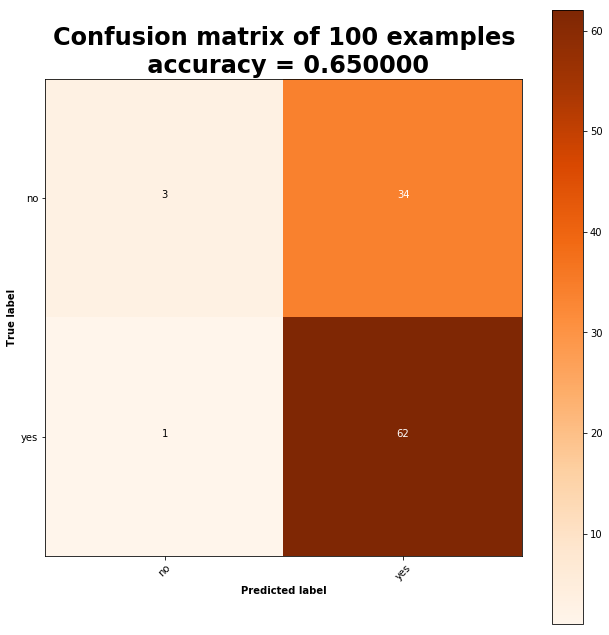

In [38]:
n_iters = 100
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

### Training functions

In [39]:
def CEtrain(s1_tensor,
            s2_tensor,
            label,
            model,
            optimizer,
            criterion):
    
    model.train()
    optimizer.zero_grad()
    logits = model(s1_tensor, s2_tensor)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()
    return loss

Test CEtrain

In [40]:
CE = nn.CrossEntropyLoss()
addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= 0.3)

loss = CEtrain(s1_tensor=example_t[0],
               s2_tensor=example_t[1],
               label=example_t[2],
               model=addmodel,
               optimizer=addmodel_opt,
               criterion=CE)
assert type(loss.item()) == float 

## Little example of training

epoch 1/10 2m 40s mean loss = 1.47
epoch 2/10 2m 41s mean loss = 0.89
epoch 3/10 2m 50s mean loss = 0.85
epoch 4/10 2m 48s mean loss = 0.81
epoch 5/10 2m 44s mean loss = 0.78
epoch 6/10 2m 50s mean loss = 0.79
epoch 7/10 3m 0s mean loss = 0.78
epoch 8/10 3m 20s mean loss = 0.75
epoch 9/10 3m 19s mean loss = 0.73
epoch 10/10 3m 5s mean loss = 0.71


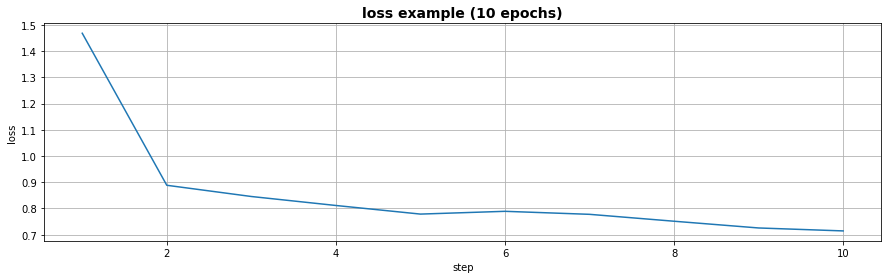

In [41]:
epochs = 10
learning_rate = 0.1

CE = nn.CrossEntropyLoss()

encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b3_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b3_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b3_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b3_decoder2_att.pkl"))

addmodel = AndModel(encoderA,
                    decoderA,
                    encoderB,
                    decoderB,
                    hidden_size=256,
                    output_size=2,
                    max_length=MAX_LENGTH,
                    input_lang=input_lang,
                    target_lang=output_lang)



# # for model in [encoderA, decoderA, encoderB, decoderB]:
# for model in [encoderB, decoderB]:
#     for param in model.parameters():
#         param.requires_grad = False

# addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= learning_rate)
addmodel_opt = torch.optim.Adagrad(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.Adadelta(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.Adam(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.SparseAdam(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.RMSprop(addmodel.parameters(), lr= learning_rate)





losses_per_epoch = []

for i in range(epochs):
    losses = []
    start = time.time()
    n_iters = 1000
    training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
    for t in training_pairs_little:
        s1, s2, label = t    
        loss = CEtrain(s1_tensor=s1,
                       s2_tensor=s2,
                       label=label,
                       model=addmodel,
                       optimizer=addmodel_opt,
                       criterion=CE)
        losses.append(loss.item())
    mean_loss = np.mean(losses)
    losses_per_epoch.append(mean_loss)
    print("epoch {}/{}".format(i+1, epochs), timeSince(start), "mean loss = {:.2f}".format(mean_loss))

simple_step_plot([losses_per_epoch],
                 "loss",
                 "loss example ({} epochs)".format(epochs),
                 "loss_example.png",
                  figsize=(15,4))

## Prediction AFTER training

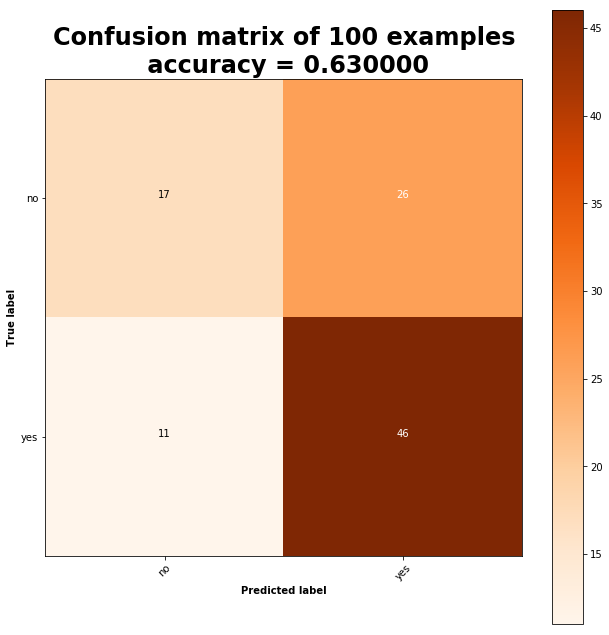

In [42]:
n_iters = 100
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

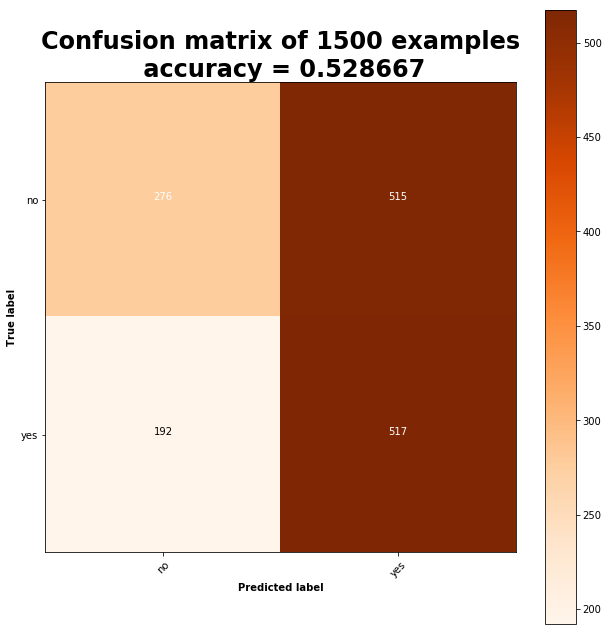

In [43]:
n_iters = len(valid_triples_t)
valid_pairs_little = [random.choice(valid_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = valid_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

In [44]:
torch.save(addmodel.state_dict(), "b3_sum.pkl")

In [45]:
# encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
# decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
# encoderA.load_state_dict(torch.load("b3_encoder1_att.pkl"))
# decoderA.load_state_dict(torch.load("b3_decoder1_att.pkl"))
# encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
# decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
# encoderB.load_state_dict(torch.load("b3_encoder2_att.pkl"))
# decoderB.load_state_dict(torch.load("b3_decoder2_att.pkl"))

# addmodel = AndModel(encoderA,
#                     decoderA,
#                     encoderB,
#                     decoderB,
#                     hidden_size=256,
#                     output_size=2,
#                     max_length=MAX_LENGTH,
#                     input_lang=input_lang,
#                     target_lang=output_lang)


# addmodel.load_state_dict(torch.load("b3_sum.pkl"))

# n_iters = len(test_triples_t)
# test_pairs_little = [random.choice(test_triples_t) for i in range(n_iters)]
# predictions = []
# labels = []

# for i in range(n_iters):
#     s1, s2, label = test_pairs_little[i]
#     pred = addmodel.predict(s1, s2)
#     label = label.item()
#     pred = pred.item()
#     predictions.append(pred)
#     labels.append(label)

# plot_confusion_matrix(labels,
#                       predictions,
#                       classes=["no", "yes"],
#                       path="confusion_matrix.png")